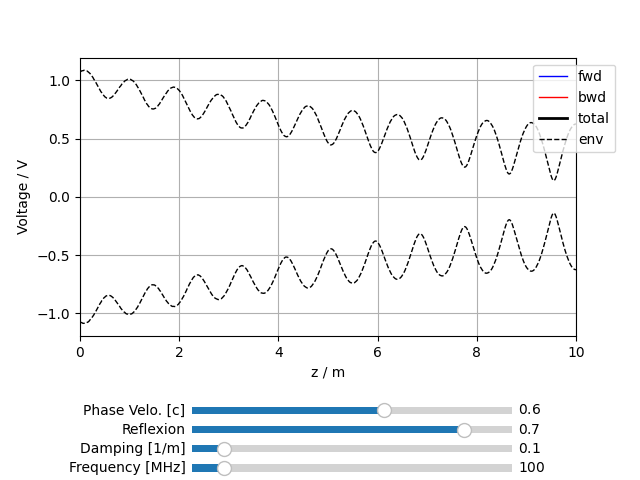

In [1]:
%matplotlib ipympl

import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.widgets import Slider,Button,RadioButtons


# define parameters
frames = 40

class TL:
    def __init__(self, freq=100e6, vp_fac=0.6, a=0.1, u_hat=1, phi=0, r=0.7, zmin=0, zmax=10, zpoints=500):
        self.__c = 299792458 # speed of light
        self.update(freq=freq, vp_fac=vp_fac, a=a, u_hat=u_hat, phi=phi, r=r, zmin=zmin, zmax=zmax, zpoints=zpoints) 

    def update(self, freq=None, vp_fac=None, a=None, u_hat=None, phi=None, r=None, zmin=None, zmax=None, zpoints=None):
        if freq is not None: 
            self.freq = freq
            self.w = 2 * np.pi * self.freq # angular frequency
            self.T = 1.0 / self.freq # period
            self.delta_t = self.T / frames
        if vp_fac is not None: 
            self.vp_fac = vp_fac
            self.v_p = self.__c * self.vp_fac
        if a is not None: self.a = a
        if u_hat is not None: self.u_hat_1 = u_hat
        if phi is not None: self.phi_1 = phi
        if r is not None: self.r = r
        if zmin is not None: self.zmin=zmin
        if zmax is not None: self.zmax=zmax
        if zpoints is not None: self.zpoints=zpoints
        self.z = np.linspace(self.zmin, self.zmax, self.zpoints, endpoint=True)
        self.b = self.w / self.v_p # propagation constant
        self.l = self.v_p / self.freq # wavelength
        # calculate u_hat_2 from reflexion coefficient r (|r| in (-1,1))
        self.u_hat_2 = self.r * self.u_hat_1 * np.exp(-2*self.a*self.zmax)
        self.phi_2 = -2*self.b*self.zmax + self.phi_1
        self.lower, self.upper = self.calc_enveloppe()
        self.umin, self.umax = (1.1*np.min(self.lower), 1.1*np.max(self.upper))
            
    def u1(self, t):
        return self.u_hat_1 * np.exp(-self.a*self.z) * np.cos(self.w*t - self.b*self.z + self.phi_1)

    def u2(self, t):
        return self.u_hat_2 * np.exp( self.a*self.z) * np.cos(self.w*t + self.b*self.z + self.phi_2)

    def u3(self, t):
        return self.u1(t) + self.u2(t)

    def calc_enveloppe(self):
        upper = np.zeros(self.zpoints)
        lower = np.zeros(self.zpoints)
        for t in self.T*np.linspace(0,1,frames,endpoint=True):
            u_3 = self.u3(t)
            upper = np.maximum(upper, u_3)
            lower = np.minimum(lower, u_3)
        return lower, upper


tl=TL()

# create a figure and axes
plt.ioff()
fig = plt.figure(figsize=(20,5))
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.3)

# set up the plot as needed
ax.set_xlim((tl.zmin, tl.zmax))            
ax.set_ylim((tl.umin, tl.umax))
ax.set_xlabel('z / m')
ax.set_ylabel('Voltage / V')
ax.grid()

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax.set_title('')
line1, = ax.plot([], [], 'b', lw=1)     # ax.plot returns a list of 2D line objects
line2, = ax.plot([], [], 'r', lw=1)
line3, = ax.plot([], [], 'k', lw=2)
line4, = ax.plot([], [], 'k--', lw=1)
line5, = ax.plot([], [], 'k--', lw=1)

# ax.legend(['fwd','bwd', 'sum']);
ax.legend(['fwd','bwd', 'total', 'env'], bbox_to_anchor=(.9, 1.0), loc='upper left')


line4.set_data(tl.z, tl.upper)
line5.set_data(tl.z, tl.lower)


# animation function. This is called sequentially
def drawframe(n, instance):
    delta_t = instance.T/frames
    t = n * delta_t
    ax.set_ylim((instance.umin, instance.umax))
    u_1 = instance.u1(t)
    u_2 = instance.u2(t)
    u_3 = u_1 + u_2
    line1.set_data(instance.z, u_1)
    line2.set_data(instance.z, u_2)
    line3.set_data(instance.z, u_3)
    txt_title.set_text(f"Time = {t/instance.T:.2f} T")
    return (line1,line2,line3,)


#partial(drawframe, instance=tl)(0)

plt.ion()

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.3, 0.01, 0.5, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [MHz]',
    valmin=0,
    valmax=1000,
    valinit=1e-6*tl.freq,
)

axdamp = fig.add_axes([0.3, 0.05, 0.5, 0.03])
damp_slider = Slider(
    ax=axdamp,
    label='Damping [1/m]',
    valmin=0,
    valmax=1,
    valinit=tl.a,
)

axref = fig.add_axes([0.3, 0.09, 0.5, 0.03])
ref_slider = Slider(
    ax=axref,
    label='Reflexion',
    valmin=-1,
    valmax=1,
    valinit=tl.r,
)

axvp = fig.add_axes([0.3, 0.13, 0.5, 0.03])
vp_slider = Slider(
    ax=axvp,
    label='Phase Velo. [c]',
    valmin=0,
    valmax=1,
    valinit=tl.vp_fac,
)

def update(val, inst):
    inst.update(freq=1e6*freq_slider.val, a=damp_slider.val, r=ref_slider.val, vp_fac=vp_slider.val)
    umin, umax = inst.umin, inst.umax
    t = 0
    u_1 = inst.u1(t)
    u_2 = inst.u2(t)
    u_3 = u_1 + u_2
    line1.set_data(inst.z, u_1)
    line2.set_data(inst.z, u_2)
    line3.set_data(inst.z, u_3)
    line4.set_data(inst.z, inst.upper)
    line5.set_data(inst.z, inst.lower)
    txt_title.set_text(f"Time = {t/inst.T:.2f} T")
    fig.canvas.draw_idle()

# register the update function with each slider
freq_slider.on_changed(partial(update, inst=tl))
damp_slider.on_changed(partial(update, inst=tl))
ref_slider.on_changed(partial(update, inst=tl))
vp_slider.on_changed(partial(update, inst=tl))

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, partial(drawframe, instance=tl), frames=frames, interval=10, blit=True)
plt.show()


# HTML(anim.to_html5_video())